$$
\newcommand{\mat}[1]{\pmb {#1}}
\newcommand{\mattr}[1]{\pmb {#1}^\top}
\newcommand{\matinv}[1]{\pmb {#1}^{-1}}
\newcommand{\vec}[1]{\pmb {#1}}
\newcommand{\vectr}[1]{\pmb {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\pmb{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
$$
# CS236605: Deep Learning
# Tutorial 2: Logistic Regression

## Introduction

In this tutorial, we will cover:

* Basics of supervised learning
* Binary logistic regression from scratch using numpy
* Multiclass logistic regression from scratch with PyTorch

In [1]:
# Setup
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 20

## Theory Reminders

### The supervised learning context

We have a labeled dataset of $N$ labelled samples: $\mathcal{D} = \{ (\vec{x}^i,y^i) \}_{i=1}^N$, where
- $\vec{x}^i = \left(x^i_1, \dots, x^i_D\right) \in \mathcal{X}$  is a **sample** or **feature vector**.
- $y^i \in \mathcal{Y}$ is the **label**.
- For classification with $C$ classes, $\mathcal{Y} = \{0,\dots,C-1\}$, so each $y^i$ is a **class label**.
- Usually we assume each labeled sample $(\vec{x}^i,y^i)$
  is drawn from a joint distribution
  $$P(\rvec{X}, \rvar{Y})=P(\rvec{X})\cdot P(\rvar{Y}|\rvec{X})$$

- Our **model** is a parametrized set of functions $\mathcal{H}$.

    For example,
    $$
    \mathcal{H} =
    \left\{ h: \mathcal{X}\rightarrow\mathcal{Y}
    ~\vert~
    h(\vec{x}) = \varphi(\vectr{w}\vec{x}+b); \vec{w}\in\set{R}^D,~b\in\set{R}\right\}
    $$
    where $\varphi(\cdot)$ is some nonlinear function, is known as the **perceptron** model.
    
    The model is **trained** by updating it's parameters to improve it's performance on some data.
    
    A model may also have **hyperparameters** which are not trained (but they can be cross-validated).
    For example, the choice of $\varphi(\cdot)$ above could be a hyperparameter.

- We define an empirical **loss function** $L_{\mathcal{D}}(h)$ as the measure of how well a function $h\in\mathcal{H}$ fits the data $\mathcal{D}$, for example
$$
L_{\mathcal{D}}(h) = \frac{1}{N} \sum_{i=1}^{N} \ell(h(\vec{x}^i), y^i) + R(h)
$$
where
    - $\ell(y,\hat{y})$ is some **pointwise loss**, e.g. MSE for regression or cross-entropy for classification (depends on on the data).
    - $R(h)$ is a regularization term (depends only on the model).

- We wish to find a parametrization of our model $h^{\ast}\in\mathcal{H}$ such that
$$
h^{\ast} = \arg\min_{h\in\mathcal{H}} L_{\mathcal{D}}(h)
$$

### Linear Regression

We're trying to learn a continuous and perhaps non-deterministic function $y=f(\vec{x})$.

- Domain: $\vec{x}^i \in \set{R}^D$
- Target: $y^i \in \set{R}$ (can of course be extended to the vector-valued case)
- Model: $\hat y = h(\vec{x}) = \vectr{w}\vec{x} + b$
- MSE loss:
    $$\begin{align}
    \ell(y,\hat{y}) &= (y-\hat{y})^2 \\
    L_{\mathcal{D}}(h) &= \frac{1}{N}\sum_{i=1}^{N}(h(\vec{x}^i)-y^i)^2 =
        \frac{1}{N}\sum_{i=1}^{N}(\vectr{w}\vec{x} + b -y^i)^2 \\
    \end{align}$$

- Optimization scheme: Closed-form solution exists!
    $$
    \vec{w}^{\ast} = (\mat{X}\mattr{X})^{-1}\mat{X}\vec{y},
    $$
    where $\mat{X}$ is a matrix with all the samples in its columns (after bias trick),
    and $\vec{y}$ is a vector of all the labels.

### Binary Logistic Regression

Actually a **classification** model. We're trying to classify data into 2 classes.

- Domain: $\vec{x}^i \in \set{R}^D$
- Target: $y^i \in \{0,1\}$
- Model: $\hat{y} = h(\vec{x}) = \sigma(\vectr{w}\vec{x}+b)$, where $\sigma(\vec{z})$ is the **logistic function**.
    - $\sigma(\vec{z}) = \frac{1}{1+e^{-\vec{z}}}$
    - Probabilistic interpretation: $\hat{y}=P(\rvar{Y}=1|\rvec{X}=\vec{x})$
- Cross-entropy loss:
    $$\begin{align}
    \ell(y, \hat{y}) &=  - y \log(\hat{y}) - (1-y) \log(1-\hat{y}) \\
    \end{align}$$
- Optimization scheme: No closed form solution, but loss is **convex** so gradient-based approach leads to global optimum.

In [2]:
# Plot the logistic function & cross-entropy loss
def logistic(z):
    return 1 / (1.0 + np.exp(-z))

x = np.arange(-5, 5, .01)
y_hat = logistic(x)
loss_y0 = -np.log(1-y_hat)
loss_y1 = -np.log(y_hat)

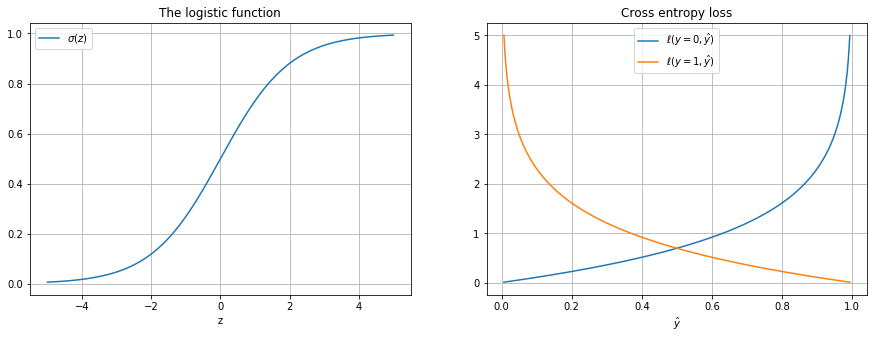

In [3]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].plot(x, y_hat, label='$\sigma(z)$')
ax[0].grid(True); ax[0].set_xlabel('z'); ax[0].legend(); ax[0].set_title('The logistic function');
ax[1].plot(y_hat, loss_y0, label='$\ell(y=0,\hat{y})$')
ax[1].plot(y_hat, loss_y1, label='$\ell(y=1,\hat{y})$')
ax[1].grid(True); ax[1].set_xlabel('$\hat{y}$'); ax[1].legend(); ax[1].set_title('Cross entropy loss');

## Part 1: Binary Logistic Regression

## Dataset

The `scikit-learn` library comes with a few [toy datasets](http://scikit-learn.org/stable/datasets/index.html#toy-datasets) that are fun to quickly train small models on.

As an example we'll load the Wisconsin-breast cancer database:
- 569 samples of cancer patients
- 30 features: various properties of tumor cells extracted from images
- 2 classes: Tumor is either Benign or Malignant

In [4]:
import sklearn.datasets

ds_cancer = sklearn.datasets.load_breast_cancer()

feature_names = ds_cancer.feature_names
target_names = ds_cancer.target_names
n_features = len(feature_names)
X, y = ds_cancer.data, ds_cancer.target
y_names = np.full_like(y, target_names[0].upper(), dtype=target_names.dtype)
y_names[y==1] = target_names[1].upper()
n_samples = len(y)

print(f'X: {X.shape}')
print(f'y: {y.shape}')
print(f'feature names: {feature_names}')
print(f'target  names: {target_names}')

X: (569, 30)
y: (569,)
feature names: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
target  names: ['malignant' 'benign']


In [5]:
# Load into a pandas dataframe and show some samples
df_cancer = pd.DataFrame(data=X, columns=ds_cancer.feature_names)
df_cancer = df_cancer.assign(CLASS=y_names)
df_cancer.iloc[100:110, 0::3]

,mean radius,mean area,mean concavity,mean fractal dimension,perimeter error,compactness error,symmetry error,worst texture,worst smoothness,worst concave points,CLASS
100,13.610,582.7,0.08625,0.05871,2.8610,0.014880,0.01465,35.27,0.1265,0.11840,MALIGNANT
101,6.981,143.5,0.00000,0.07818,1.5530,0.010840,0.02659,19.54,0.1584,0.00000,BENIGN
102,12.180,458.7,0.02383,0.05677,1.1830,0.006098,0.01447,32.84,0.1123,0.07431,BENIGN
103,9.876,298.3,0.06154,0.06322,1.5280,0.021960,0.01609,26.83,0.1559,0.09749,BENIGN
104,10.490,336.1,0.02995,0.06481,2.3020,0.022190,0.02710,23.31,0.1219,0.03203,BENIGN
105,13.110,530.2,0.20710,0.07692,2.4100,0.029120,0.01547,22.40,0.1862,0.19860,MALIGNANT
106,11.640,412.5,0.07070,0.06520,2.1550,0.023100,0.01565,29.26,0.1688,0.12180,BENIGN
107,12.360,466.7,0.02643,0.06066,0.8484,0.010470,0.01251,27.49,0.1184,0.08442,BENIGN
108,22.270,1509.0,0.42640,0.07039,10.0500,0.086680,0.03112,28.01,0.1701,0.29100,MALIGNANT
109,11.340,396.5,0.05133,0.06529,1.5970,0.015570,0.01568,29.15,0.1699,0.08278,BENIGN


In [6]:
# Split into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f'train: X={X_train.shape} y={y_train.shape}')
print(f'test : X={X_test.shape} y={y_test.shape}')

train: X=(398, 30) y=(398,)
test : X=(171, 30) y=(171,)


In [7]:
# Standardize the features
mu_X = np.mean(X_train, axis=0)
sigma_X = np.std(X_train, axis=0)

# Note1: each feature is standardized individually:
print(f'mu_X: {mu_X}')
print(f'sigma_X: {mu_X}')

# Note2: Test set must be transformed identically to training set
X_train_sc = (X_train - mu_X) / sigma_X
X_test_sc = (X_test - mu_X) / sigma_X

mu_X: [1.40938467e+01 1.93415327e+01 9.16989447e+01 6.50784171e+02
 9.57892714e-02 1.03143442e-01 8.84457681e-02 4.80487286e-02
 1.80492965e-01 6.27095729e-02 3.91917085e-01 1.19798166e+00
 2.77358819e+00 3.82153342e+01 6.98150251e-03 2.53617487e-02
 3.21848910e-02 1.15316784e-02 2.06816231e-02 3.80615352e-03
 1.62665603e+01 2.58163065e+01 1.07220678e+02 8.79696734e+02
 1.32259095e-01 2.57169975e-01 2.78709540e-01 1.14484601e-01
 2.92937688e-01 8.42292211e-02]
sigma_X: [1.40938467e+01 1.93415327e+01 9.16989447e+01 6.50784171e+02
 9.57892714e-02 1.03143442e-01 8.84457681e-02 4.80487286e-02
 1.80492965e-01 6.27095729e-02 3.91917085e-01 1.19798166e+00
 2.77358819e+00 3.82153342e+01 6.98150251e-03 2.53617487e-02
 3.21848910e-02 1.15316784e-02 2.06816231e-02 3.80615352e-03
 1.62665603e+01 2.58163065e+01 1.07220678e+02 8.79696734e+02
 1.32259095e-01 2.57169975e-01 2.78709540e-01 1.14484601e-01
 2.92937688e-01 8.42292211e-02]


## Model Implementation

We'll implement based on the above definitions.

The model will be implemented as a class with an API that conforms to the `sklearn` models, specifically see
`sklearn`'s [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) class.


In [8]:
class BinaryLogisticRegression(object):
    def __init__(self, n_iter=100, learn_rate=0.1):
        self.n_iter = n_iter
        self.learn_rate = learn_rate

    def predict_proba(self, X, add_bias=True):
        if add_bias:
            Xb = np.hstack((np.ones((X.shape[0],1)), X))
        else:
            Xb = X
        Z = np.dot(Xb, self.w_)
        return logistic(Z)
    
    def predict(self, X):
        proba = self.predict_proba(X)
        y_pred = np.zeros((X.shape[0],), dtype=np.int)
        y_pred[proba > 0.5] = 1
        return y_pred
    
    def fit(self, X, y):
        self.losses_ = []
        # Init weights
        n, d = X.shape
        self.w_ = np.random.randn(d+1) * 0.1
        for i in range(self.n_iter):
            # Forward pass
            Xb = np.hstack((np.ones((X.shape[0],1)), X))
            y_hat = self.predict_proba(Xb, add_bias=False)
            # Calculate loss & gradient
            loss = -y.dot(np.log(y_hat)) - ((1 - y).dot(np.log(1 - y_hat)))
            self.losses_.append(loss)
            loss_grad = 1/n * Xb.T.dot(y_hat - y)
            # Update weights
            self.w_ += -self.learn_rate * loss_grad
        return self

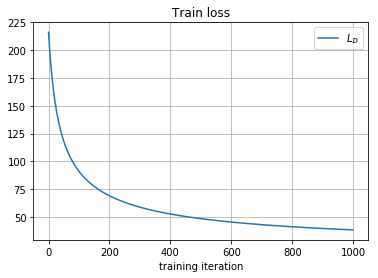

In [9]:
# Fit the model to the training data
lr_model = BinaryLogisticRegression(n_iter=1000, learn_rate=0.01)
lr_model.fit(X_train_sc, y_train)

plt.plot(lr_model.losses_, label='$L_{\mathcal{D}}$');
plt.xlabel('training iteration'); plt.legend(); plt.grid(True); plt.title('Train loss');

In [10]:
# Predict on test data
y_test_pred = lr_model.predict(X_test_sc)
test_acc = np.sum(y_test_pred == y_test)/len(y_test)
print(f'test set accuracy: {test_acc*100:.2f}%')

test set accuracy: 97.08%


**Notes:**

1. To train the model, we used gradient descent for a fixed number of iterations and using the gradient of the entire dataset. Both of these things are bad ideas for large datasets. As you'll see further down, usually large models are trained in **batches** with **stochastic gradient descent**.

2. Derivation of the binary cross-entropy  gradient is left as an exercise.

## Part 2: Multiclass Logistic Regression

What if we have $C$ classes? Can we still use logistic regression?

A naïve approach is to train $C$ binary logistic regression classifiers in a One vs. Rest scheme,
and then predict based on the classifier returning the greatest probability.

One major drawback of this approach is that it doesn't really create a probility distribution over the classes. 

For example, a sample might be classified as class A with probability $0.8$ and class $B$ with $0.7$ since nothing constrains the different classifiers.

### The softmax function

Let's create a way to generate a probability distribution for our $C$ classes given their scores.
We'll define a function called **softmax** as follows:

$$
\mathrm{softmax}(\vec{z}) = \frac{e^{\vec{z}}}{\sum_{j=1}^{C} e^{z_j}}
$$

note that this is a vector valued, multivariate function. The exponent in the enumerator operates elementwise.

The result of softmax is a vector with elements in $[0,1]$ that all sum to $1$.

### The multiclass model

Our model can now be defined as

$$\hat{\vec{y}} = h(\vec{x}) = \mathrm{softmax}(\mattr{W}\vec{x}+\vec{b})$$

where,
- $\hat{\vec{y}}$ is a $C\times 1$ vector of class probabilities.
- ${\vec{x}}$ is a $D\times 1$ sample.
- $\mat{W}$ is a $D\times C$ matrix representing the per-class weights.
- $\vec{b}$ is a per-class bias vector of length $C$.

Probabilistic interpretation: $\hat{y}_j = P(\rvar{Y}=j|\rvec{X}=\vec{x})$.

- To train such a model we need our labels to also be probability distributions instead of simply the number of the correct class.

- We'll transform our labels to a 1-hot encoded vector corresponding to a delta distribution.

    For example, if $y^i=j$ then we'll create
    $$
    \vec{y}^i = [0,\dots,0,\underbrace{1}_{j\mathrm{th\ component}},0,\dots,0]^\top
    $$

### Cross-Entropy loss

After defing the 1-hot label vectors, the multiclass extension of the binary cross-entropy is straightforward:

$$
\ell(\vec{y}, \hat{\vec{y}}) = - \vectr{y} \log(\hat{\vec{y}})
$$

Note that only the probability assigned to the correct class affects the loss.

This can be interpreted as trying to move the probability distribution created by the model towards the delta distribution.

### Dataset

This time we'll tackle an image classification task, the MNIST database of handwritten digits.

Today this is also considered a toy dataset, even though it was used in the past to benchmark state of the art classification algorithms.

x0: torch.Size([1, 28, 28]), y0: 5


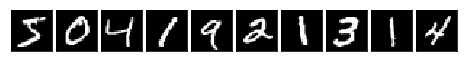

In [11]:
import torch
import torch.utils.data
import torchvision
import torchvision.transforms as tvtf
import plot_utils

# Define the transforms that should be applied to each image in the dataset before returning it
tf_ds = tvtf.Compose([
    tvtf.ToTensor(), # Convert PIL image to pytorch Tensor
    tvtf.Normalize(mean=(0.1307,), std=(0.3081,))
])

batch_size = 128

# Training dataset
ds_train = torchvision.datasets.MNIST(root='./data/mnist/', download=True, train=True, transform=tf_ds)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True)

# Test dataset & loader
ds_test =  torchvision.datasets.MNIST(root='./data/mnist/', download=True, train=False, transform=tf_ds)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size)

x0, y0 = ds_train[0]
n_features = torch.numel(x0)
n_classes = 10

print(f'x0: {x0.shape}, y0: {y0}')
plot_utils.dataset_first_n(ds_train, 10, cmap='gray');

### Model Implementation

This time we'll use `pytorch` tensors and it's [`autograd`](https://pytorch.org/docs/stable/autograd.html) functionality to implement our model.

In [12]:
def softmax(z):
    # z is a batch of class scores per sample (N,C)
    zmax, _ = torch.max(z, dim=1, keepdim=True)
    z = z - zmax # normalization trick to prevent numerical instability: shift so that the highest number is 0
    e_to_z = torch.exp(z)
    return e_to_z / torch.sum(e_to_z, dim=1, keepdim=True)

In [13]:
def cross_entropy(y, y_hat):
    # y is a batch of probabilities (N,C)
    return - torch.sum( y * torch.log(y_hat + 1e-6) )

In [14]:
def sgd_optimizer(params, learn_rate):
    with torch.autograd.no_grad():
        for param in params:
            param -= learn_rate * param.grad
            param.grad.zero_()

In [15]:
def onehot(class_labels, n_classes):
    y_onehot = torch.zeros(class_labels.shape[0], n_classes, dtype=torch.float32)
    y_onehot = y_onehot.scatter(1,class_labels.reshape(-1,1),1)
    return y_onehot

In [16]:
class MCLogisticRegression(object):
    def __init__(self):
        # Specify we want to track gradients with autograd
        self.W = torch.randn(n_features, n_classes, requires_grad=True)
        self.b = torch.randn(n_classes, requires_grad=True)
        self.params = [self.W, self.b]
    
    def __call__(self, *args):
        return self.forward(*args)

    def forward(self, X):
        z = torch.mm(X, self.W) + self.b
        y_hat = softmax(z)
        return y_hat


In [17]:
def evaluate_accuracy(dataloader, model):
    n_correct = 0.
    n_total = 0.
    for i, (X, y) in enumerate(dataloader):
        X = X.reshape((-1,n_features))
        with torch.autograd.no_grad():
            y_hat = model(X)
        
        predictions = torch.argmax(y_hat, dim=1)
        n_correct += torch.sum(predictions == y).type(torch.float32)
        n_total += X.shape[0]
        
    return (n_correct / n_total).item()

test_set_acc = evaluate_accuracy(dl_test, MCLogisticRegression())
print(f'Test set accuracy pre-training: {test_set_acc*100:.2f}%')

Test set accuracy pre-training: 12.45%


In [18]:
epochs = 5
learn_rate = .005
num_samples = len(ds_train)
model = MCLogisticRegression()

# Epoch: traverse all samples
for e in range(epochs):
    cumulative_loss = 0

    # Update model per data batch with SGD
    for i, (X, y) in enumerate(dl_train):
        X = X.reshape((-1,n_features))
        y_onehot = onehot(y, n_classes)
        
        # Forward pass
        y_hat = model(X)
        loss = cross_entropy(y_onehot, y_hat)
        
        # Backward pass & parameter update
        loss.backward()
        sgd_optimizer(model.params, learn_rate)
        
        cumulative_loss += torch.sum(loss).item()

    test_accuracy = evaluate_accuracy(dl_test, model)
    train_accuracy = evaluate_accuracy(dl_train, model)
    
    avg_loss = cumulative_loss/num_samples
    print(f"Epoch {e}. Loss: {avg_loss:.3f}, Train Acc {train_accuracy*100:.2f}, Test Acc {test_accuracy*100:.2f}")   

Epoch 0. Loss: 2.374, Train Acc 88.02, Test Acc 88.12
Epoch 1. Loss: 1.144, Train Acc 89.56, Test Acc 89.85
Epoch 2. Loss: 0.984, Train Acc 90.91, Test Acc 90.69
Epoch 3. Loss: 0.904, Train Acc 91.45, Test Acc 90.84
Epoch 4. Loss: 0.844, Train Acc 91.64, Test Acc 90.94


**Notes:**
- This is a very basic implementation. We didn't even include any regularization term which would be a problem if this weren't a toy dataset.
- PyTorch provides many functions and classes that we could have used, for example:
  - Perceptron fully connected layer with model parameters
  - Softmax
  - SGD and many other optimizers
  - Cross entropy loss
  
  however the purpose here was to show a from-scratch implementation using only tensors,
  in order to see whats "under the hood" (more or less) of the PyTorch functions.